# Train-test of XPINN poisson

In [1]:
import jax.numpy as np
import numpy as onp
import optax
from jax import vmap, lax
from pathlib import Path

from base_network import neural_network
from plotutils import plot_losses, plot_poisson
from poisson.poisson_utils import (
    boundary_loss_factory,
    interior_loss_factory,
    crude_rel_L2,
    interface_loss_factory,
)
from utils import data_path
from xpinn import XPINN
from type_util import Array

In [2]:
file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh

# Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

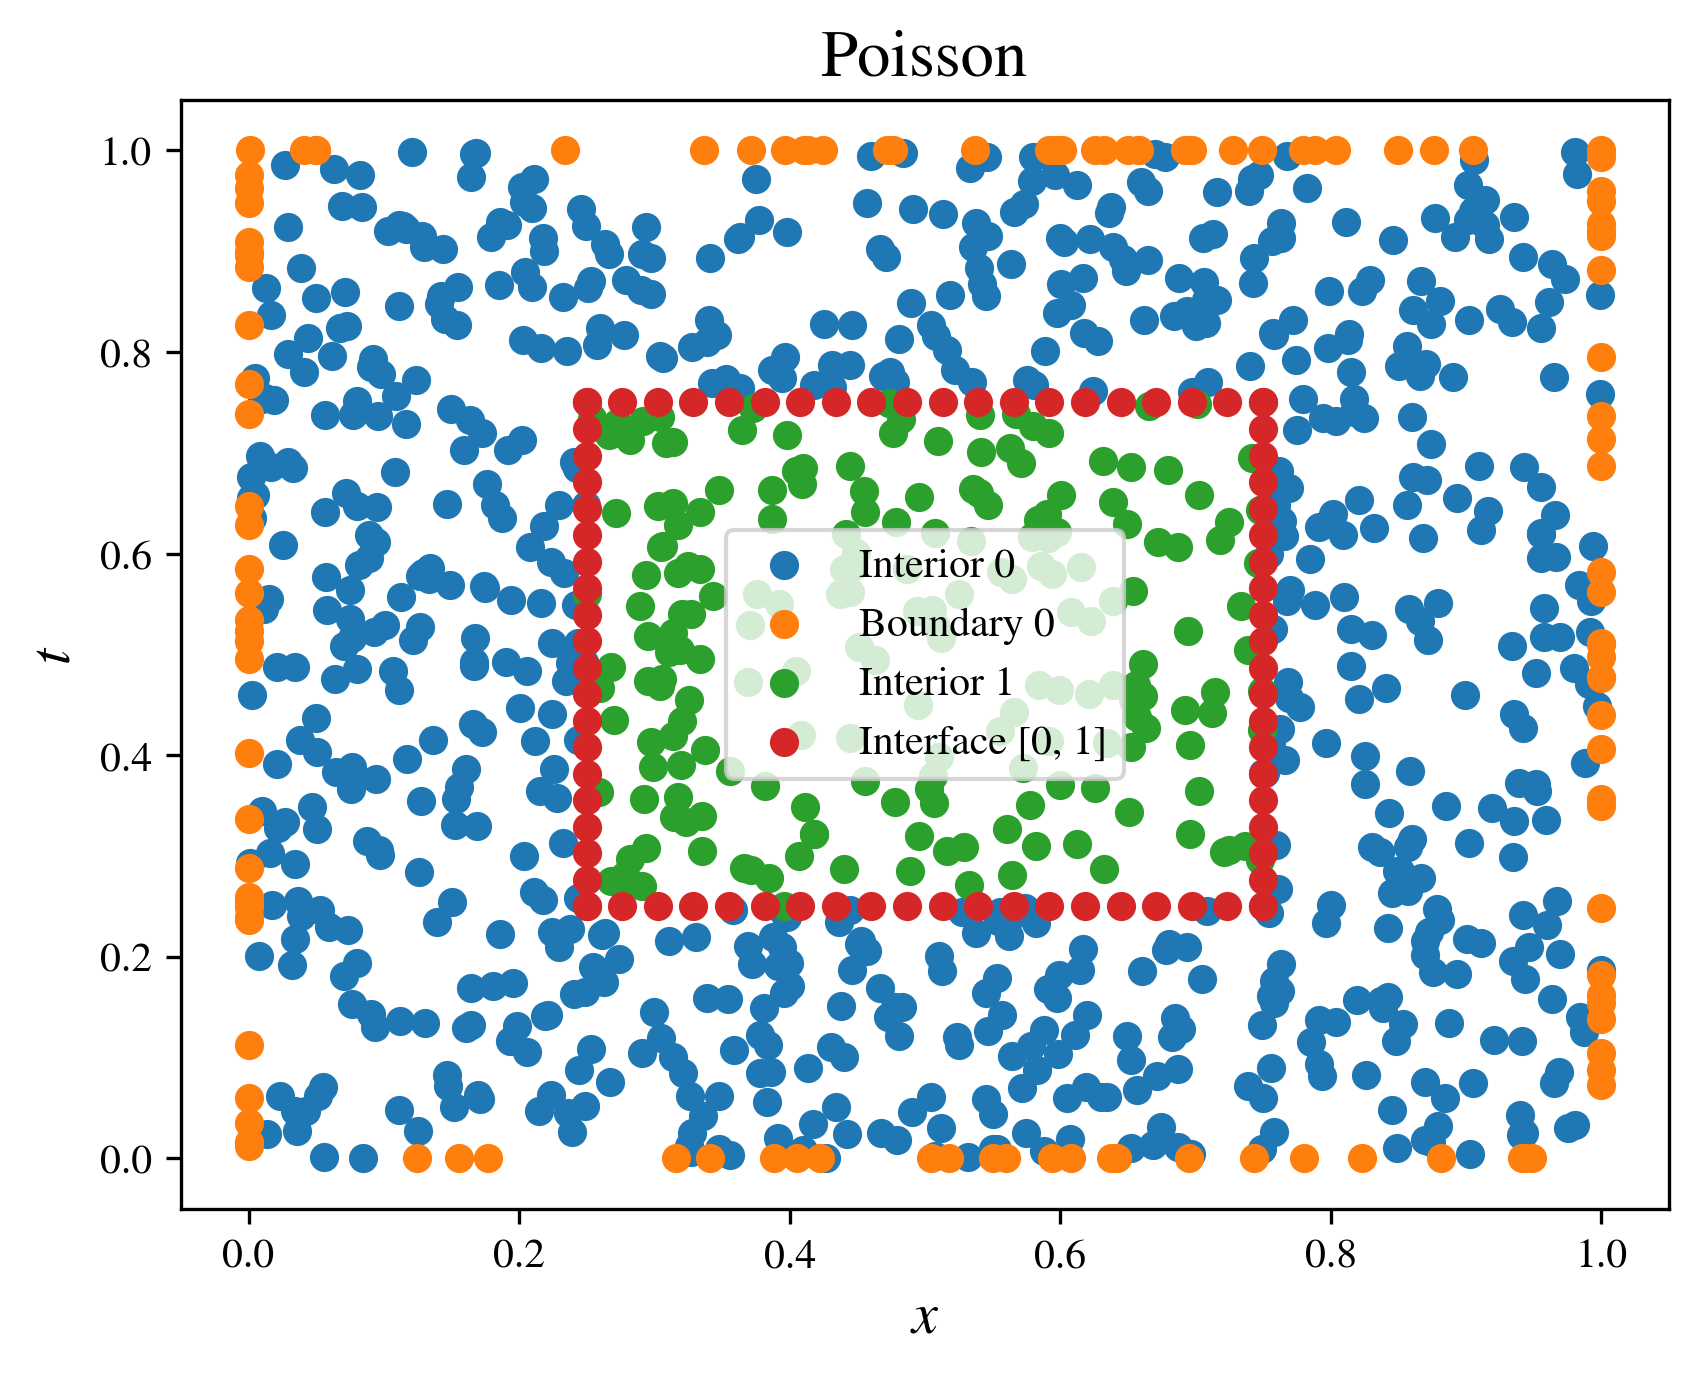

In [3]:
from plotutils import plot_domain

plot_domain(xpinn, data_path, "Poisson", "poisson")

In [4]:
# Set losses
def rhs(point: Array) -> Array:
    """The right-hand side of the Poisson equation.

    Args:
        point (Array): A point in the domain.

    Returns:
        Array: The value of the right-hand side at the point.
    """
    x = point[0]
    y = point[1]
    x_cond = (0.25 <= x) & (x <= 0.75)
    y_cond = (0.25 <= y) & (y <= 0.75)
    condition = x_cond & y_cond

    return lax.select(condition, -1.0, 0.0)


p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0, 0.0, weight=20.0)
p0.interior_loss = interior_loss_factory(p0, rhs)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, rhs)
p0.interface_loss = interface_loss_factory(xpinn, 0, 1, weight=20.0)
p1.interface_loss = interface_loss_factory(xpinn, 1, 0, weight=20.0)

In [6]:
# Initializing optimizer
shapes = [[2] + [20] * 7 + [1]] * 2
exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.00001,
)
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)
xpinn.set_loss()

In [7]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 4.144007205963135
10.00% iter = 20000 of 200000: Total loss = 0.05752597562968731
20.00% iter = 40000 of 200000: Total loss = 0.03536033444106579
30.00% iter = 60000 of 200000: Total loss = 0.029389044269919395
40.00% iter = 80000 of 200000: Total loss = 0.02440460864454508
50.00% iter = 100000 of 200000: Total loss = 0.020459088496863842
60.00% iter = 120000 of 200000: Total loss = 0.018050601240247488
70.00% iter = 140000 of 200000: Total loss = 0.0165272019803524
80.00% iter = 160000 of 200000: Total loss = 0.01584617095068097
90.00% iter = 180000 of 200000: Total loss = 0.014814029447734356
100.00% iter = 200000 of 200000: Total loss = 0.014331084676086903


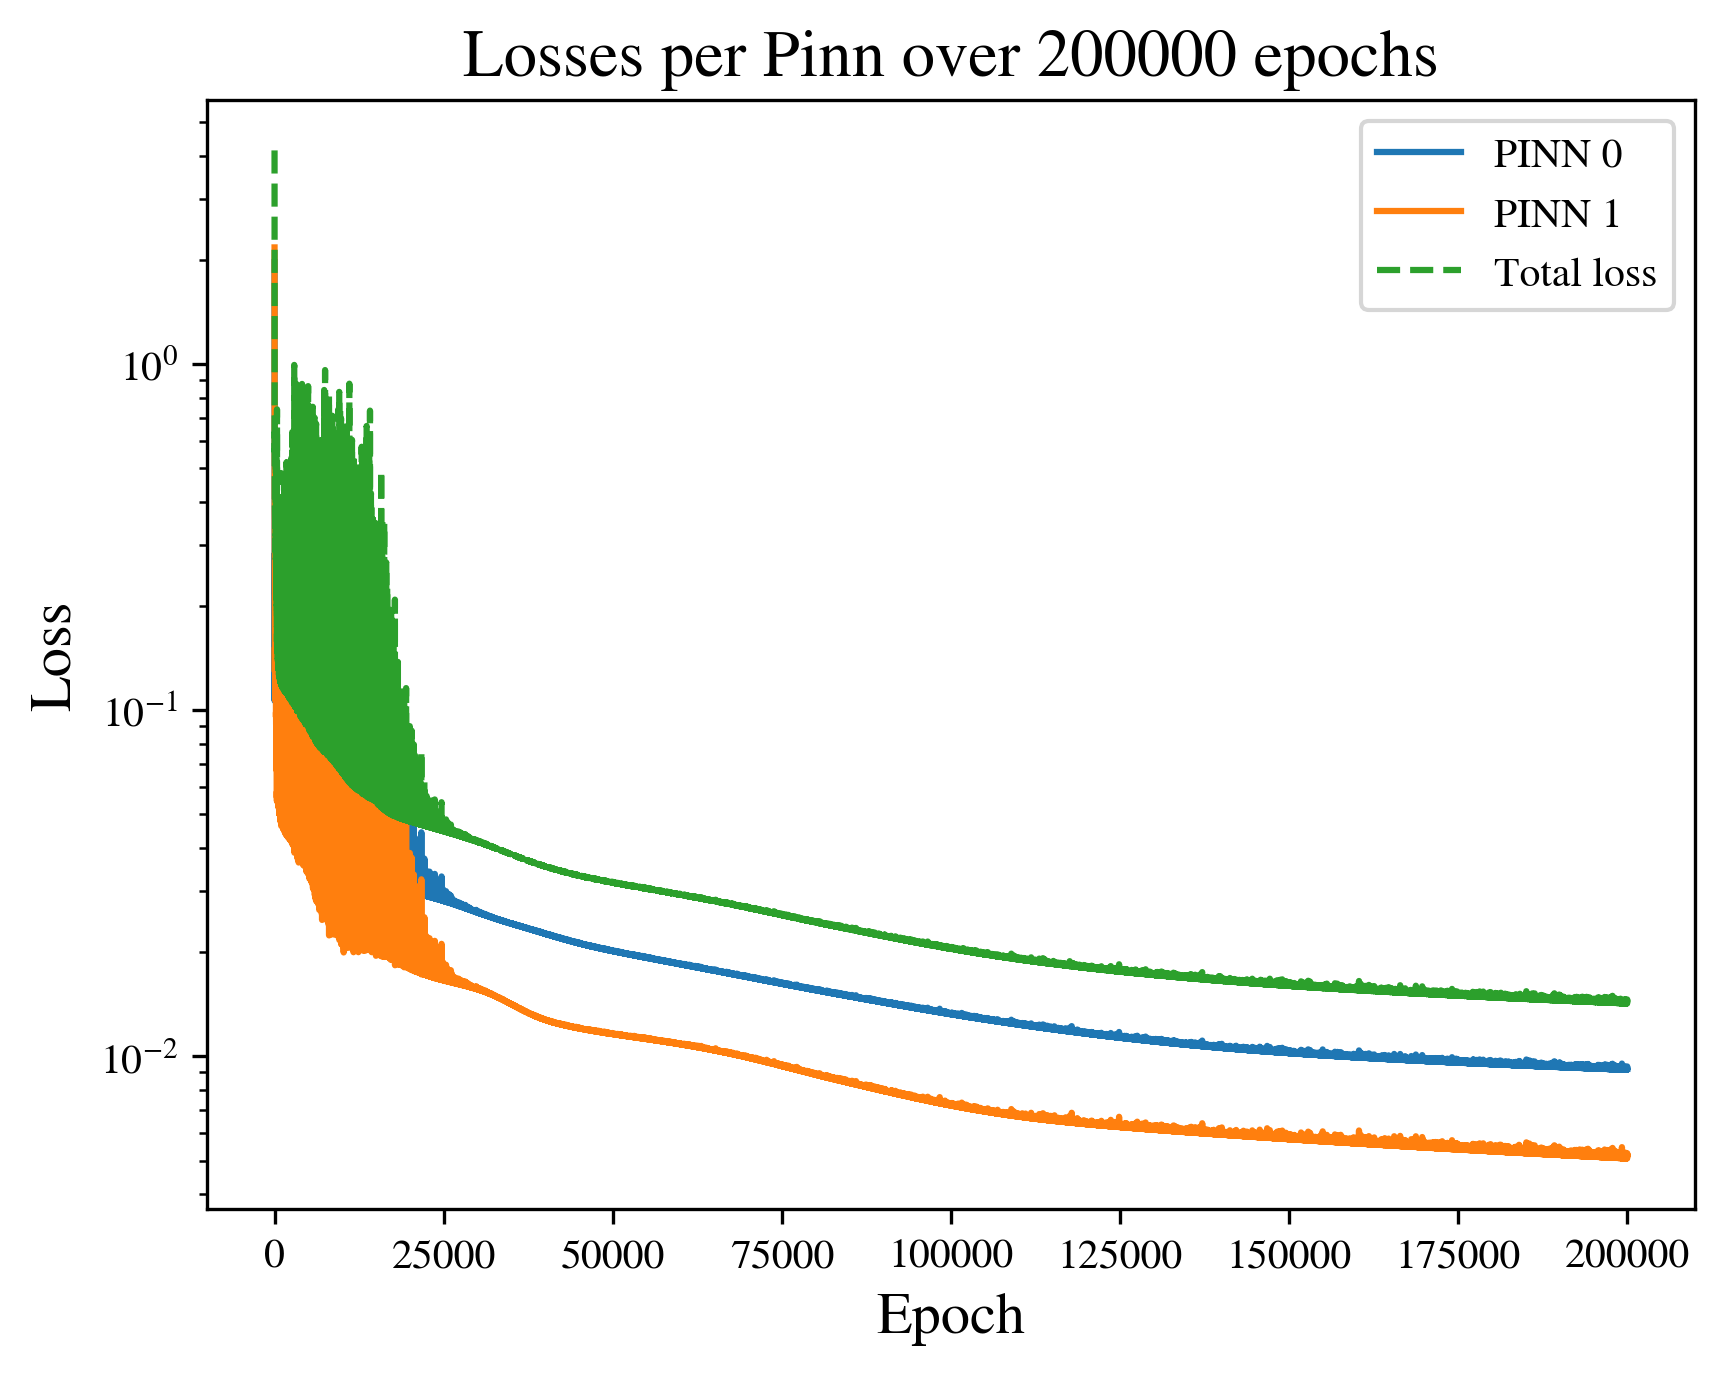

In [8]:
save_path = data_path.parent / "figures/Poisson/new_exp"
save_path.mkdir(parents=True, exist_ok=True)


plot_losses(
    losses,
    n_iter,
    title=f"Losses per Pinn over {n_iter} epochs",
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_losses",
)

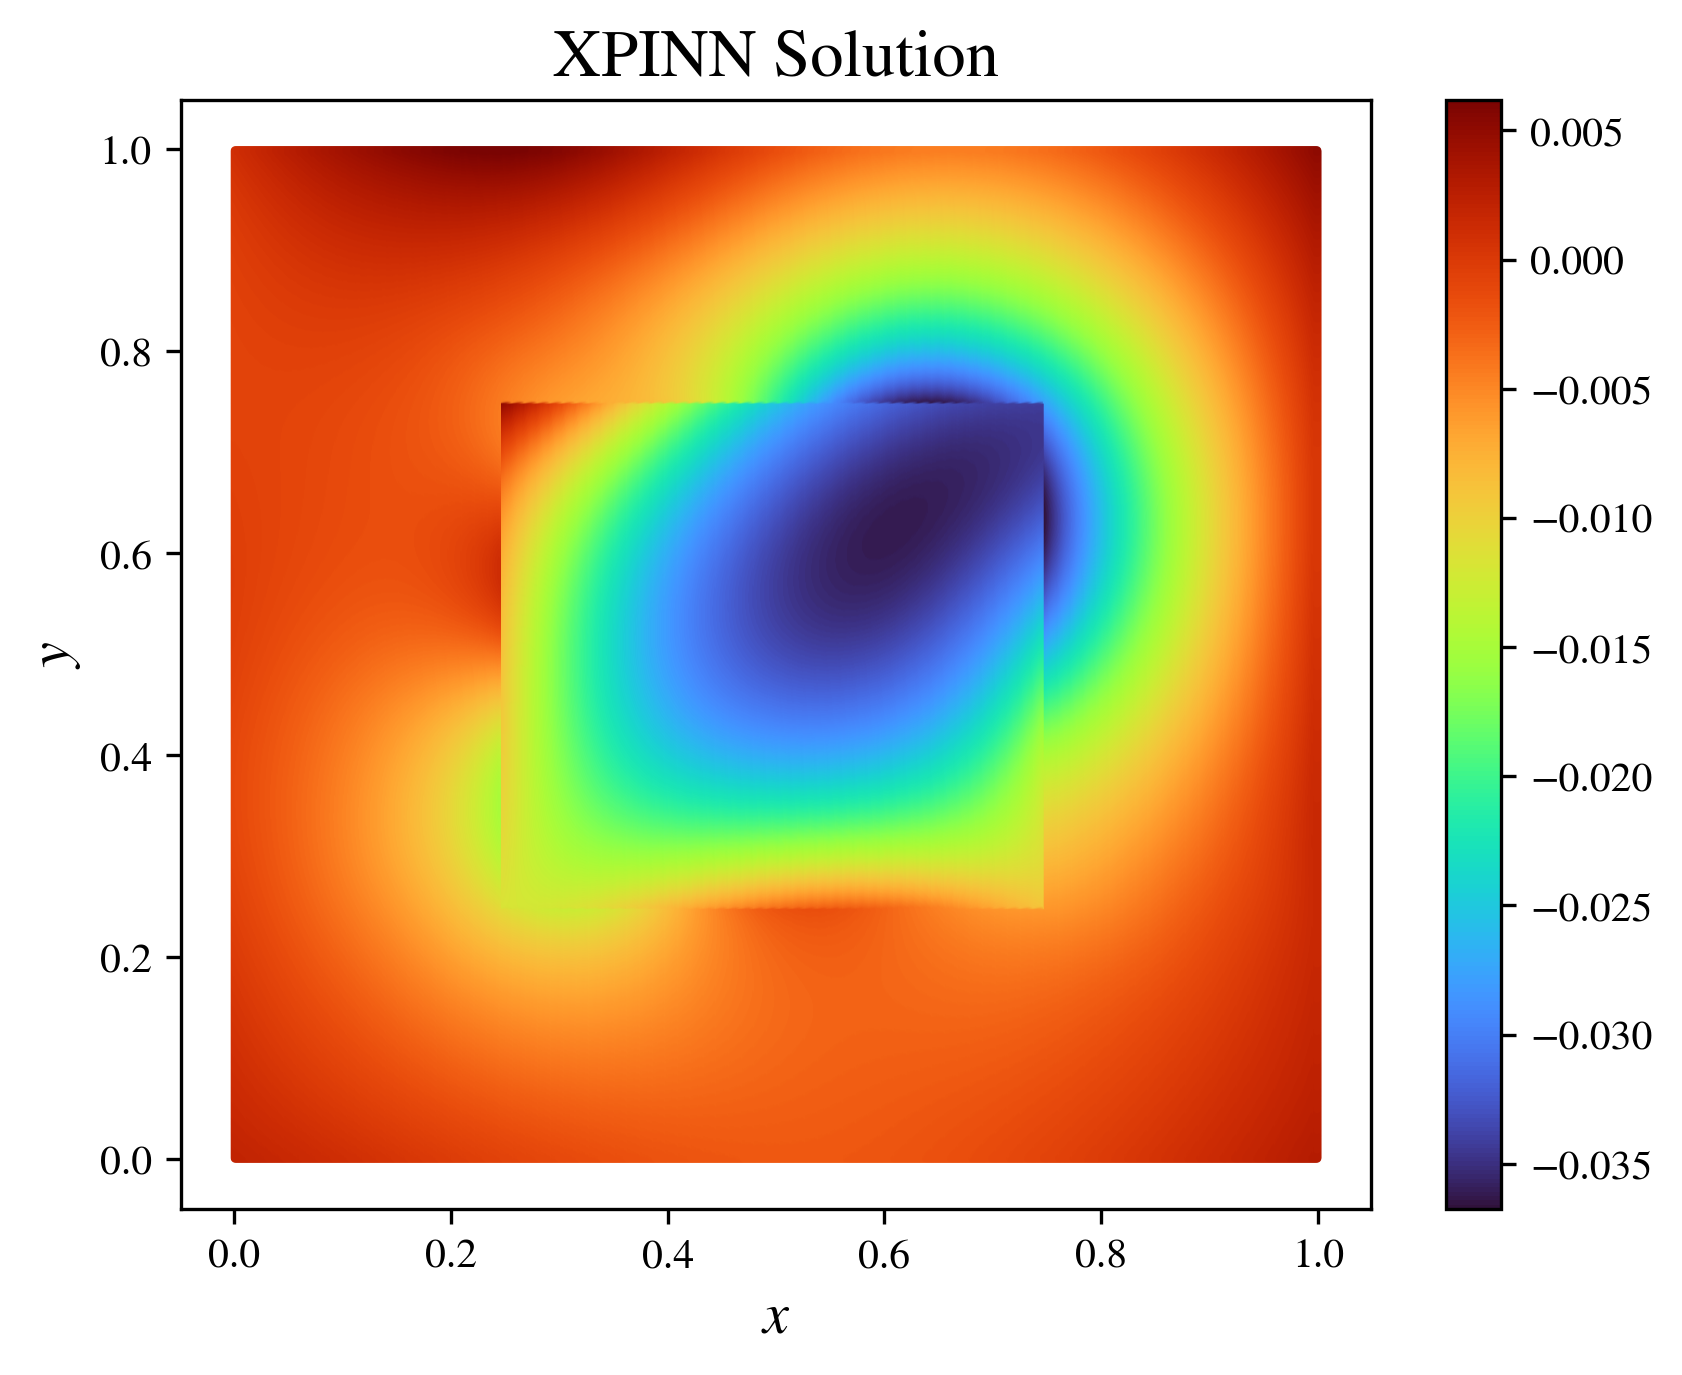

In [9]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)

sorted_indices = np.lexsort((total_points[:, 1], total_points[:, 0]))
total_pred = total_pred[sorted_indices]
total_points = total_points[sorted_indices]

plot_poisson(
    total_points,
    total_pred,
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_solution",
    title="XPINN Solution",
)

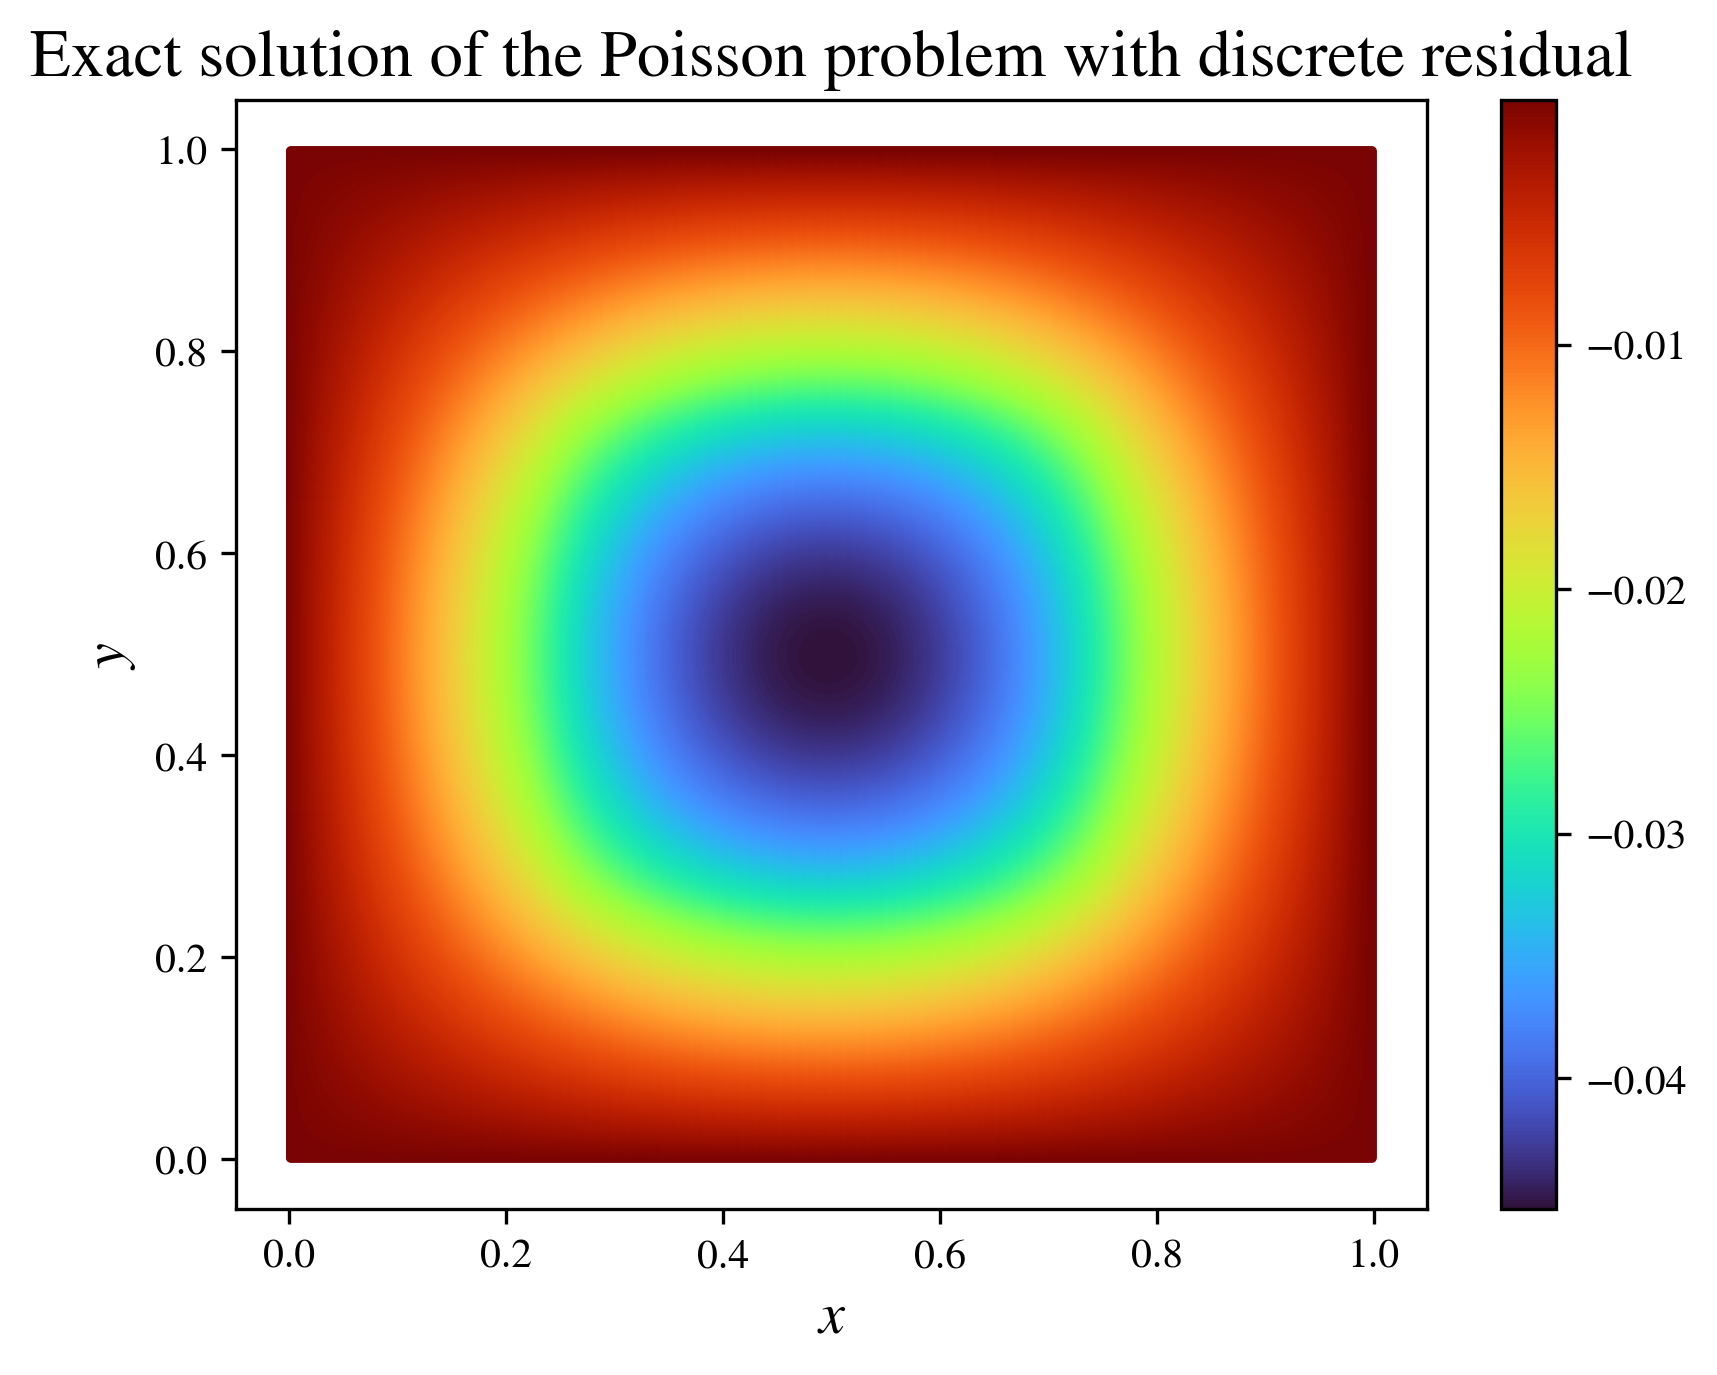

In [10]:
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

plot_poisson(
    total_points,
    true_sol,
    title="Exact solution of the Poisson problem with discrete residual",
    savepath=save_path,
    save_name="discrete_Poisson_solution",
)

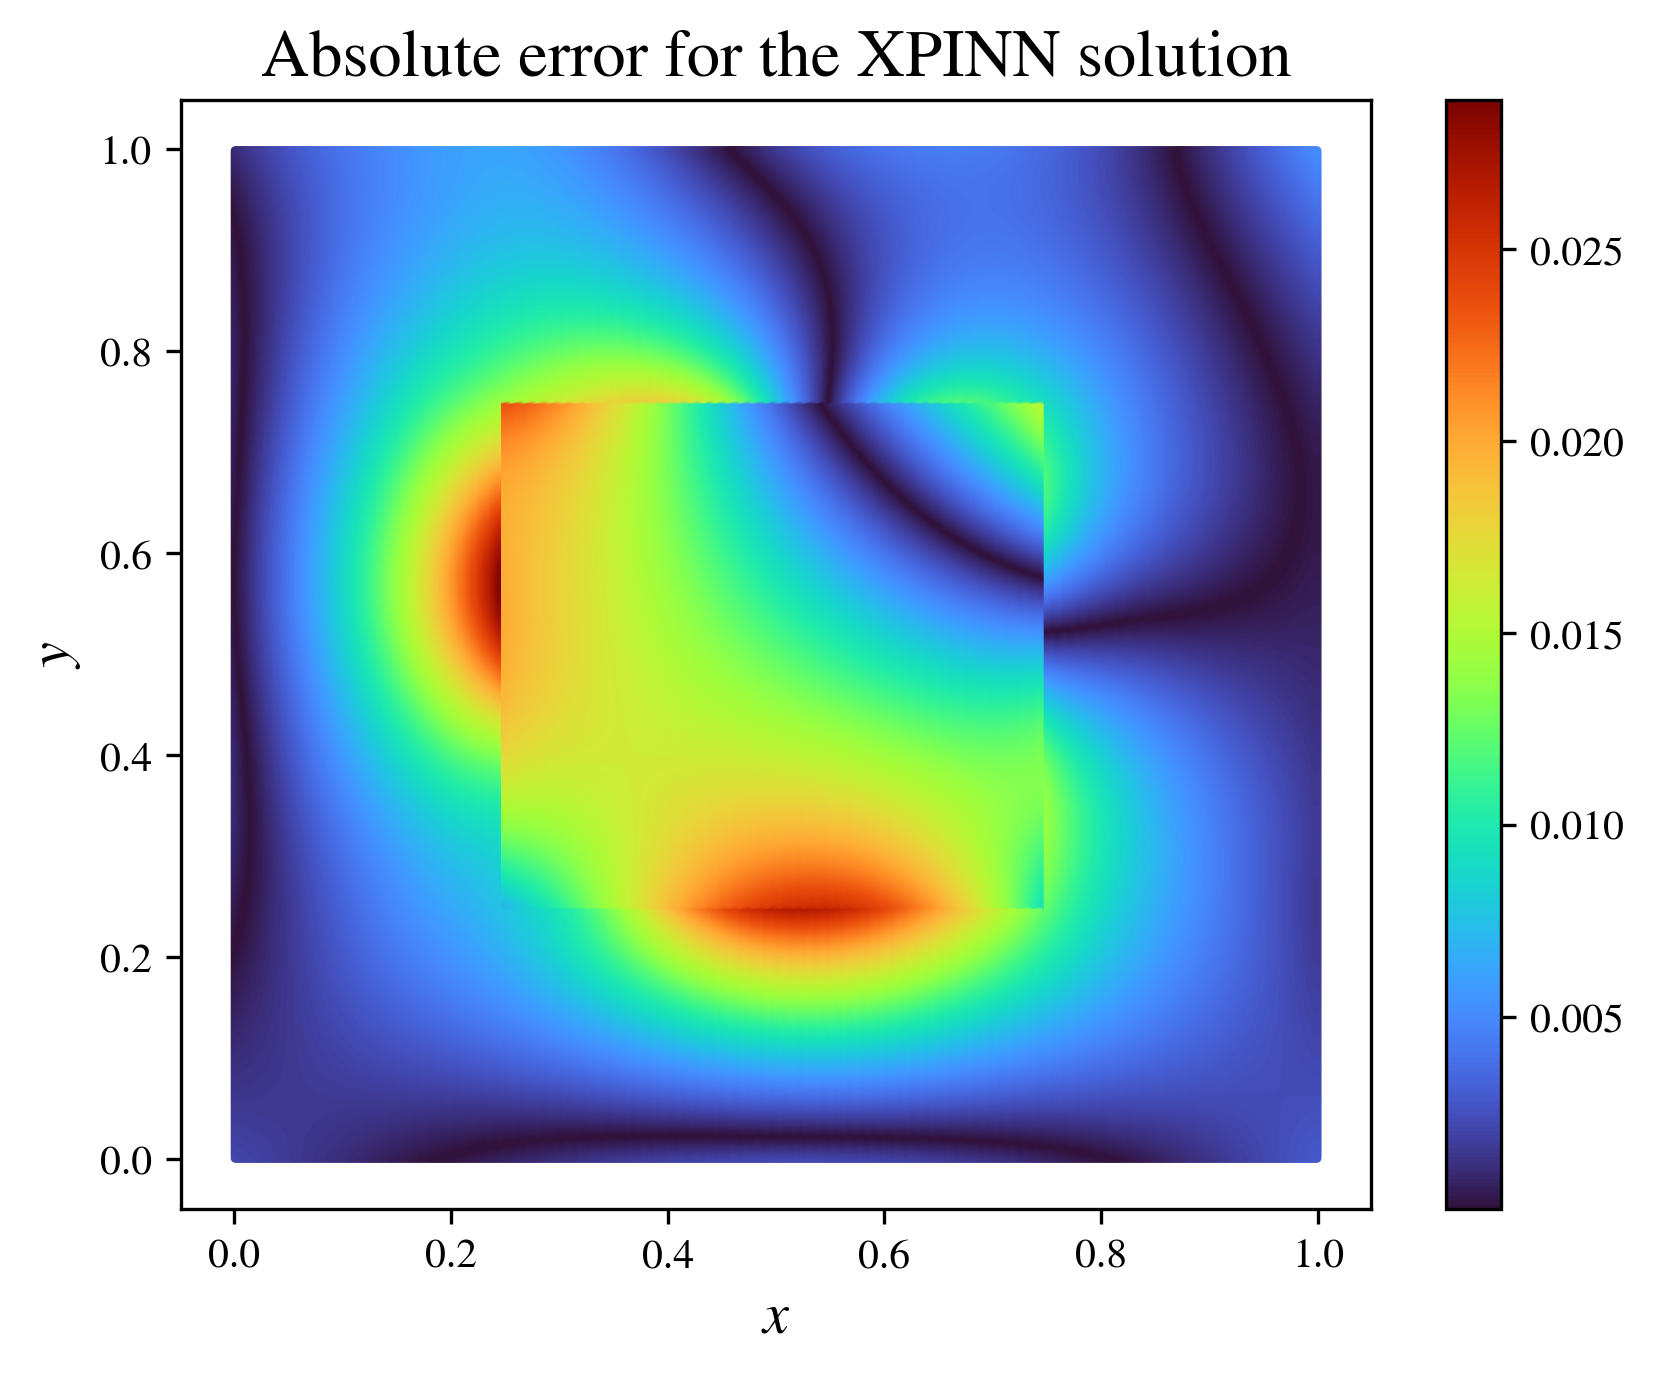

In [11]:
error = np.abs(true_sol - total_pred)

plot_poisson(
    total_points,
    error,
    title="Absolute error for the XPINN solution",
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_error",
)

In [12]:
sorted_indices = np.lexsort((total_points[:, 1], total_points[:, 0]))
sorted_pred = total_pred[sorted_indices]

# Getting true value
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

true_integral = np.sqrt(np.sum(true_sol**2))
# Setting the L2 relative errors
l2_error = crude_rel_L2(sorted_pred, true_sol, true_integral)
print(l2_error)

0.46098632
